In [10]:
from pathlib import Path
from pprint import pprint

import imageio
import torch

import lerobot
from lerobot.common.datasets.lerobot_dataset import LeRobotDataset

import h5py
import numpy as np
import matplotlib.pyplot as plt

In [3]:
repo_id = "lerobot/pusht" 
dataset = LeRobotDataset(repo_id)

dataset

Fetching 212 files: 100%|██████████| 212/212 [00:00<00:00, 11729.38it/s]


LeRobotDataset(
  Repository ID: 'lerobot/pusht',
  Split: 'train',
  Number of Samples: 25650,
  Number of Episodes: 206,
  Type: video (.mp4),
  Recorded Frames per Second: 10,
  Camera Keys: ['observation.image'],
  Video Frame Keys: ['observation.image'],
  Transformations: None,
  Codebase Version: v1.6,
)

In [ ]:
# torch.save(dataset, 'dataset.pth')

In [9]:
# d2 = torch.load('dataset.pth')

In [8]:
# d2

In [10]:
hf_dataset=dataset.hf_dataset
hf_dataset

Dataset({
    features: ['observation.image', 'observation.state', 'action', 'episode_index', 'frame_index', 'timestamp', 'next.reward', 'next.done', 'next.success', 'index'],
    num_rows: 25650
})

In [11]:
first_episode = hf_dataset.filter(lambda x: x['episode_index'] == 0)
first_episode

Filter: 100%|██████████| 25650/25650 [00:00<00:00, 27458.97 examples/s]


Dataset({
    features: ['observation.image', 'observation.state', 'action', 'episode_index', 'frame_index', 'timestamp', 'next.reward', 'next.done', 'next.success', 'index'],
    num_rows: 161
})

In [16]:
first_episode['observation.image'] 
first_episode['action'][:5] 

[tensor([233.,  71.]),
 tensor([229.,  83.]),
 tensor([229.,  86.]),
 tensor([230.,  86.]),
 tensor([239.,  89.])]

In [23]:
def extract_episode(lerobot_dataset, episode_index):
    from_idx = lerobot_dataset.episode_data_index["from"][episode_index].item()
    to_idx = lerobot_dataset.episode_data_index["to"][episode_index].item()
    episode = [lerobot_dataset[idx] for idx in range(from_idx, to_idx)]
    return episode

In [24]:
episode=extract_episode(dataset, 0)
len(episode)

161

In [25]:
row=episode[0]
row.keys()

dict_keys(['observation.image', 'observation.state', 'action', 'episode_index', 'frame_index', 'timestamp', 'next.reward', 'next.done', 'next.success', 'index'])

In [27]:
row['episode_index'], row['frame_index'], row['timestamp'], row['index']

(tensor(0), tensor(0), tensor(0.), tensor(0))

In [57]:
def extract_frames(episode):
    actions=np.array([row['action'] for row in episode] )
    dactions = np.diff(actions, axis=0)
    dactions = np.concatenate([dactions, np.zeros((1, 2))], axis=0)
    states=np.array([row['observation.state'] for row in episode] )
    images=np.array([row['observation.image'] for row in episode] ) 
    images = images.transpose(0, 2, 3, 1)
    return states, images, actions, dactions

In [58]:
episode=extract_episode(dataset, 10)
states, images, actions, dactions = extract_frames(episode)
states.shape, images.shape, actions.shape, dactions.shape

((188, 2), (188, 96, 96, 3), (188, 2), (188, 2))

In [65]:
n_episode=len(dataset.episode_data_index['from'])
n_episode

206

In [66]:
hdf5_file_name='pusht_hf_206.hdf5'

env_args = "" 
f_sub = h5py.File(hdf5_file_name, "w")
f_sub.create_group("data")
f_sub.create_group("mask")
f_sub["data"].attrs["env_args"] = env_args
f_sub.close()

In [67]:
for demo_no in range(n_episode):
    episode=extract_episode(dataset, demo_no)
    states, images, actions, dactions = extract_frames(episode)

    demo_group=f"/data/demo_{demo_no}"
    print(f'saving demo {demo_group} to {hdf5_file_name}')
    with h5py.File(hdf5_file_name, 'a') as hf:
        group = hf.create_group(demo_group) 
        group.attrs['num_samples'] = states.shape[0]
        group.create_dataset('obs/images', data=images)      
        group.create_dataset('obs/states', data=states)
        group.create_dataset('dactions', data=dactions)
        group.create_dataset('actions', data=actions)

saving demo /data/demo_0 to pusht_hf_206.hdf5
saving demo /data/demo_1 to pusht_hf_206.hdf5
saving demo /data/demo_2 to pusht_hf_206.hdf5
saving demo /data/demo_3 to pusht_hf_206.hdf5
saving demo /data/demo_4 to pusht_hf_206.hdf5
saving demo /data/demo_5 to pusht_hf_206.hdf5
saving demo /data/demo_6 to pusht_hf_206.hdf5
saving demo /data/demo_7 to pusht_hf_206.hdf5
saving demo /data/demo_8 to pusht_hf_206.hdf5
saving demo /data/demo_9 to pusht_hf_206.hdf5
saving demo /data/demo_10 to pusht_hf_206.hdf5
saving demo /data/demo_11 to pusht_hf_206.hdf5
saving demo /data/demo_12 to pusht_hf_206.hdf5
saving demo /data/demo_13 to pusht_hf_206.hdf5
saving demo /data/demo_14 to pusht_hf_206.hdf5
saving demo /data/demo_15 to pusht_hf_206.hdf5
saving demo /data/demo_16 to pusht_hf_206.hdf5
saving demo /data/demo_17 to pusht_hf_206.hdf5
saving demo /data/demo_18 to pusht_hf_206.hdf5
saving demo /data/demo_19 to pusht_hf_206.hdf5
saving demo /data/demo_20 to pusht_hf_206.hdf5
saving demo /data/demo_

In [5]:
hdf5_file_name='pusht_hf_206.hdf5'

In [6]:
f=h5py.File(hdf5_file_name, 'r')
print(f.keys())
print(f['data'].keys())
print(f['data']['demo_1'].keys())
print(f['data']['demo_1']['obs'].keys())
print(f['data']['demo_1']['obs']['images'].shape)
print(f['data']['demo_1']['obs']['states'].shape)

<KeysViewHDF5 ['data', 'mask']>
<KeysViewHDF5 ['demo_0', 'demo_1', 'demo_10', 'demo_100', 'demo_101', 'demo_102', 'demo_103', 'demo_104', 'demo_105', 'demo_106', 'demo_107', 'demo_108', 'demo_109', 'demo_11', 'demo_110', 'demo_111', 'demo_112', 'demo_113', 'demo_114', 'demo_115', 'demo_116', 'demo_117', 'demo_118', 'demo_119', 'demo_12', 'demo_120', 'demo_121', 'demo_122', 'demo_123', 'demo_124', 'demo_125', 'demo_126', 'demo_127', 'demo_128', 'demo_129', 'demo_13', 'demo_130', 'demo_131', 'demo_132', 'demo_133', 'demo_134', 'demo_135', 'demo_136', 'demo_137', 'demo_138', 'demo_139', 'demo_14', 'demo_140', 'demo_141', 'demo_142', 'demo_143', 'demo_144', 'demo_145', 'demo_146', 'demo_147', 'demo_148', 'demo_149', 'demo_15', 'demo_150', 'demo_151', 'demo_152', 'demo_153', 'demo_154', 'demo_155', 'demo_156', 'demo_157', 'demo_158', 'demo_159', 'demo_16', 'demo_160', 'demo_161', 'demo_162', 'demo_163', 'demo_164', 'demo_165', 'demo_166', 'demo_167', 'demo_168', 'demo_169', 'demo_17', 'demo

In [8]:
demo=f['data']['demo_0']
actions=demo['actions'][:]
states=demo['obs']['states'][:]

actions.shape, states.shape

((161, 2), (161, 2))

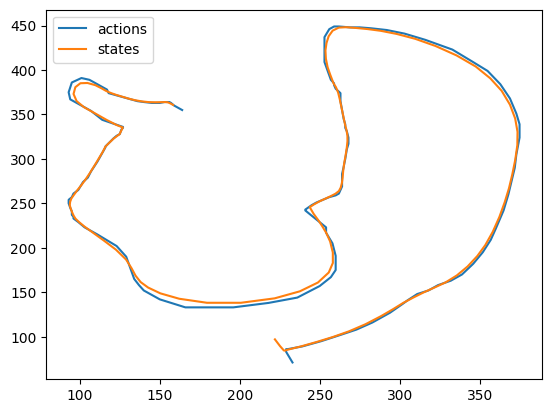

In [12]:
plt.plot(actions[:,0], actions[:,1],  label='actions')
plt.plot(states[:,0], states[:,1],   label='states')
plt.legend()